# **Predicting Health Insurance**

**Introduction to Data Science 2024/2025 | Group Q**

| Name          | Number      |
| ------------- | ----------- |
| Athos Freitas | up202108792 |
| José Santos   | up202108729 |
| Luís Du       | up202105385 |

## **Table of contents**

- [1. Business Understanding](#1-business-understanding)
- [2. Data Understanding](#2-data-understanding)
  - [2.1. Initial Data Collection](#21-initial-data-collection-and-description)
  - [2.2. Data Description](#22-data-description)
  - [2.3. Data Exploration](#23-data-exploration)
    - [2.3.1. Age](#231-age)
    - [2.3.2. Income](#232-income)
    - [2.3.1. Sex](#231-age)
    - [2.3.1. Health insurance](#231-age)
    - [2.3.1. Recent move](#231-age)
    - [2.3.1. Number of vehicles](#231-age)
    - [2.3.1. Gas Usage](#231-age)
    - [2.3.3. Income by age group](#233-income-by-age-group)
    - [2.3.4. Probability of health insurance by age]()
    - [2.3.5. Marital status by housing type]()
    - [2.3.6. Health insurance by marital status]()
    - [2.3.7. Correlation Matrix]()
    - [2.3.8. Customer by state of residence]()
    - [2.3.9. Code column by state of residence]()
  - [2.3. Data Exploration](#23-data-exploration)
- [3. Data Preparation](#3-data-preparation)
- [4. Modelling](#231-age)


## **1. Business Understanding**

| **Category**                          | **Details**                                                                 |
|---------------------------------------|-----------------------------------------------------------------------------|
| Background                            | In the US, health insurance is important for the financial security of the population. Companies aim to improve enrollment rates. Predicting whether a customer is likely to take up insurance can help optimize resource allocation and improve customer engagement strategies. |
| Business Objectives                   | Build a model to predict which of your customers don’t have health insurance. |
| Business Success Criteria             | Successfully predict the customers that don't have health insurance according to the provided data. |
| Inventory of Resources                | **Data**: A dataset with demographic and behavioral attributes such as employment status, income, housing type, marital status, and more. <br> **Tools**: Python Libraries, Jupyter Notebook. |
| Assumptions                           | Data accurately reflects the characteristics of customers.                   |
| Constraints                           | Data imbalance in certain attributes.                                        |
| Risks and Contingencies               | **Risk**: Missing values or noisy data could reduce model accuracy. <br> **Contingency**: Data cleaning and preprocessing steps. |
| Costs and Benefits                    | **Costs**: Initial setup, data preprocessing, and operationalizing the model. <br> **Benefits**: Improved conversion rates and data-driven decision-making. |
| Data Mining Goals                     | Develop a predictive model to classify customers based on their likelihood to purchase health insurance. <br> Identify the most influential factors that drive insurance uptake. |
| Data Mining Success Criteria          | Model accuracy above 80%. <br> Identify the top 5 features that influence insurance uptake. |


## **2. Data Understanding**

In [1097]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import Markdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers,  backend as K

class Utils:
    
    def __init__(self, df):
        self.df = df
        custom_palette = ['#7464D1', '#451176', '#FF0000', '#0000FF', '#00FF00']
        sns.set_palette(custom_palette)
    
    # Print statistics
    
    def update_df(self, df):
        self.df = df
        
    def print_stats(self, feature):
        table = '| Label | Count | Percentage |\n| --- | --- | --- |\n'
        
        feature_with_na = self.df[feature].fillna('Missing')
        for label in feature_with_na.value_counts().index:
            count = feature_with_na.value_counts()[label]
            percentage = count / len(self.df) * 100
            table += '| {} | {} | {:.2f} % |\n'.format(label, count, percentage)
            
        return Markdown(table)
    
    def print_numeric_stats(self, feature):
        table = '| Statistics | Value |\n'
        table += '| --- | --- |\n'
        table += '| Mean | {:.2f} |\n'.format(self.df[feature].mean())
        table += '| Standard Deviation | {:.2f} |\n'.format(self.df[feature].std())
        table += '| Minimum | {:.2f} |\n'.format(self.df[feature].min())
        table += '| 25th percentile | {:.2f} |\n'.format(self.df[feature].quantile(0.25))
        table += '| Median | {:.2f} |\n'.format(self.df[feature].median())
        table += '| 75th percentile | {:.2f} |\n'.format(self.df[feature].quantile(0.75))
        table += '| Maximum | {:.2f} |'.format(self.df[feature].max())
        table += '| IQR | {:.2f} |'.format(self.df[feature].quantile(0.75) - self.df[feature].quantile(0.25))
        table += '| Skewness | {:.2f} |'.format(self.df[feature].skew())
        table += '| Kurtosis | {:.2f} |'.format(self.df[feature].kurt())
        table += '| NA values | {} |'.format(self.df[feature].isna().sum())
        return Markdown(table)

    # Plot statistics

    def plot_stats(self, feature, with_target_value=False):        
        plt.figure(figsize=(8, 4))
        
        if with_target_value:
            sns.boxplot(x=feature, data=self.df, hue='health_ins')
        else:
            sns.boxplot(x=feature, data=self.df)

        plt.title(f'{feature} boxplot')
        plt.show()
        
        
    # Plot distribution
        
    def plot_dist(self, feature):
        pd.crosstab(self.df[feature].fillna('Missing'), self.df['health_ins']).plot(kind='bar', stacked=True)
        plt.title(f'{feature} distribution')
        plt.xticks(rotation=45)
        plt.show()
        
    def plot_numeric_dist(self, feature, plot_outliers=True):
        # Calculate outliers using the IQR method
        Q1 = self.df[feature].quantile(0.25)
        Q3 = self.df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Split the data into inliers and outliers
        inliers = self.df[(self.df[feature] >= lower_bound) & (self.df[feature] <= upper_bound)][feature]
        outliers = self.df[(self.df[feature] < lower_bound) | (self.df[feature] > upper_bound)][feature]

        # Plot inliers (blue) and outliers (light red)
        sns.histplot(inliers, kde=True, bins=20, color='blue', label='Inliers') 
        if plot_outliers:
            sns.histplot(outliers, kde=True, bins=20, color='lightcoral', label='Outliers')
            plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound: {lower_bound:.2f}')
            plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper Bound: {upper_bound:.2f}')

        plt.legend()
        plt.title(f'{feature} distribution')
        plt.show()
        

### **2.1. Initial Data Collection**

In [1098]:
import numpy as np

df = pd.read_csv('customer.csv')
utils = Utils(df)

df.head()

,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
0,7,000006646_03,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,1047,210.0,3,F
1,8,000007827_01,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,1047,3.0,6,T
2,9,000008359_04,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,1047,40.0,3,F
3,10,000008529_01,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,1047,120.0,2,F
4,11,000008744_02,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,1047,3.0,2,F


In [1099]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72458 entries, 0 to 72457
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      72458 non-null  int64  
 1   custid          72458 non-null  object 
 2   sex             72458 non-null  object 
 3   is_employed     46943 non-null  object 
 4   income          72458 non-null  float64
 5   marital_status  72458 non-null  object 
 6   health_ins      72458 non-null  bool   
 7   housing_type    70772 non-null  object 
 8   num_vehicles    70772 non-null  float64
 9   age             72458 non-null  int64  
 10  state_of_res    72458 non-null  object 
 11  code_column     72458 non-null  int64  
 12  gas_usage       70772 non-null  float64
 13  rooms           72458 non-null  int64  
 14  recent_move_b   70771 non-null  object 
dtypes: bool(1), float64(3), int64(4), object(7)
memory usage: 7.8+ MB


### **2.2. Data Description**

In [1100]:
df.describe()

,Unnamed: 0,income,num_vehicles,age,code_column,gas_usage,rooms
count,72458.000000,7.245800e+04,70772.000000,72458.000000,72458.000000,70772.000000,72458.000000
mean,49910.637556,4.188143e+04,2.066820,49.208893,3285.523572,41.230501,3.494549
std,28772.082702,5.827460e+04,1.170076,18.090035,2661.775225,63.149323,1.706537
min,7.000000,-6.900000e+03,0.000000,0.000000,131.000000,1.000000,1.000000
25%,24911.250000,1.070000e+04,1.000000,34.000000,1305.000000,3.000000,2.000000
50%,49838.000000,2.640000e+04,2.000000,48.000000,2269.000000,10.000000,3.000000
75%,74786.750000,5.200000e+04,3.000000,62.000000,4979.000000,60.000000,5.000000
max,100000.000000,1.257000e+06,6.000000,120.000000,8962.000000,570.000000,6.000000


#### ➜ **Number of observations and variables**

The dataset has **72458** observations and **15** variables

In [1101]:
df.shape

(72458, 15)

#### ➜ **Variable types**

| Type        | Number | Variables                                                        |
| ----------- | ------ | ---------------------------------------------------------------- |
| Numeric     | 7      | unamed, income, num_vehicles, age, code_column, gas_usage, rooms |
| Text        | 2      | custid, state_of_res                                             |
| Categorical | 3      | sex, marital_status, housing_type                                |
| Boolean     | 3      | is_employed, health_ins, recent_move_b                           |


#### ➜ **Missing values**

In [1102]:
df.isnull().sum()

Unnamed: 0            0
custid                0
sex                   0
is_employed       25515
income                0
marital_status        0
health_ins            0
housing_type       1686
num_vehicles       1686
age                   0
state_of_res          0
code_column           0
gas_usage          1686
rooms                 0
recent_move_b      1687
dtype: int64

#### ➜ **Duplicate rows**

In [1103]:
df.duplicated().sum()

np.int64(0)

### **2.3. Data Exploration**

#### **2.3.1. Sex**

##### **➜ Sex Statistics**

In [1104]:
utils.print_stats(feature='sex')

| Label | Count | Percentage |
| --- | --- | --- |
| Female | 37461 | 51.70 % |
| Male | 34997 | 48.30 % |


##### **➜ Sex Distribution**

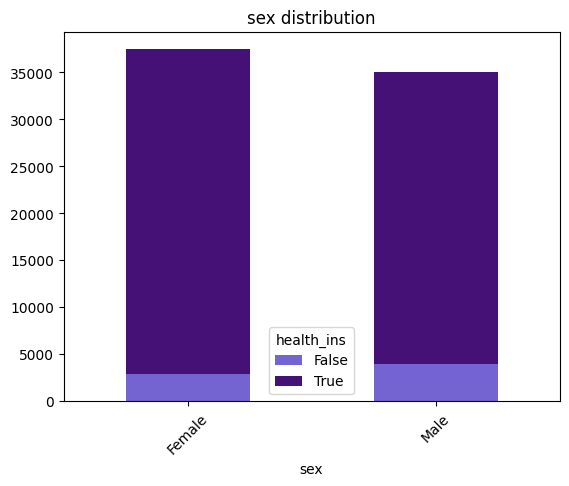

In [1105]:
utils.plot_dist(feature='sex')

#### **2.3.2. Is employed**

##### **➜ Employed Statistics**

In [1106]:
utils.print_stats(feature='is_employed')

| Label | Count | Percentage |
| --- | --- | --- |
| True | 44630 | 61.59 % |
| Missing | 25515 | 35.21 % |
| False | 2313 | 3.19 % |


##### **➜ Employed Distribution**

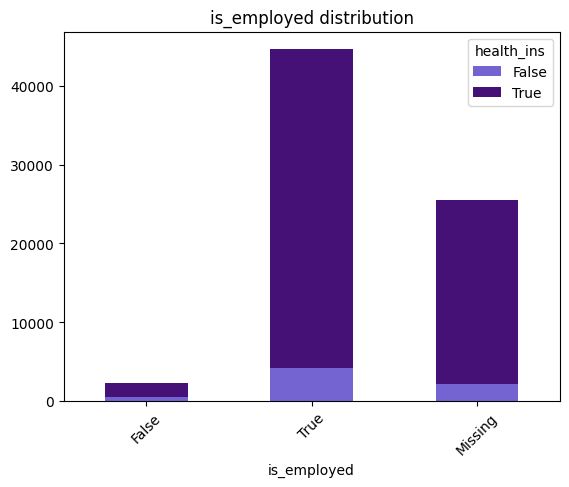

In [1107]:
utils.plot_dist(feature='is_employed')

#### **2.3.3. Income**

##### **➜ Income Statistics**

In [1108]:
utils.print_numeric_stats(feature='income')

| Statistics | Value |
| --- | --- |
| Mean | 41881.43 |
| Standard Deviation | 58274.60 |
| Minimum | -6900.00 |
| 25th percentile | 10700.00 |
| Median | 26400.00 |
| 75th percentile | 52000.00 |
| Maximum | 1257000.00 || IQR | 41300.00 || Skewness | 4.87 || Kurtosis | 37.94 || NA values | 0 |

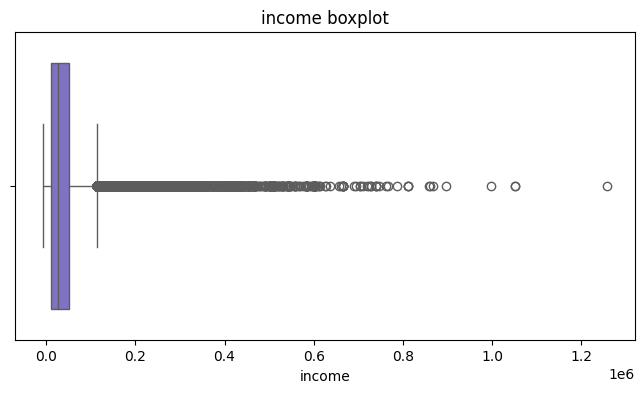

In [1109]:
utils.plot_stats('income')

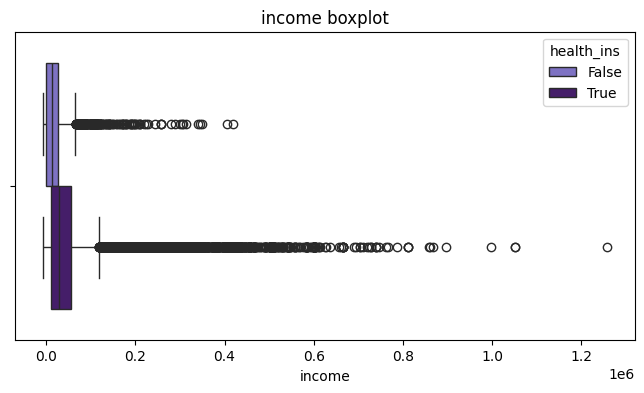

In [1110]:
utils.plot_stats('income', with_target_value=True)

##### **➜ Income Distribution**

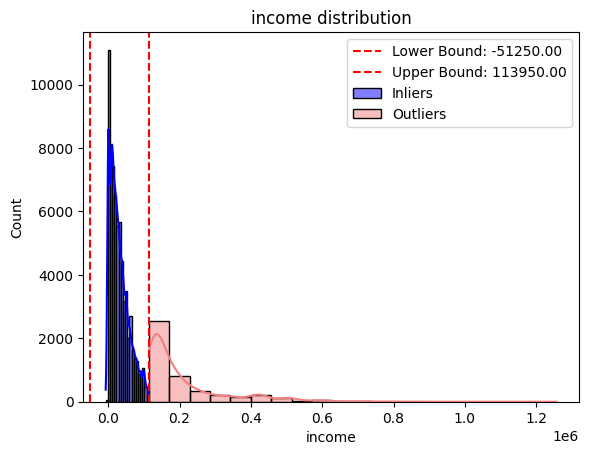

In [1111]:
utils.plot_numeric_dist('income')

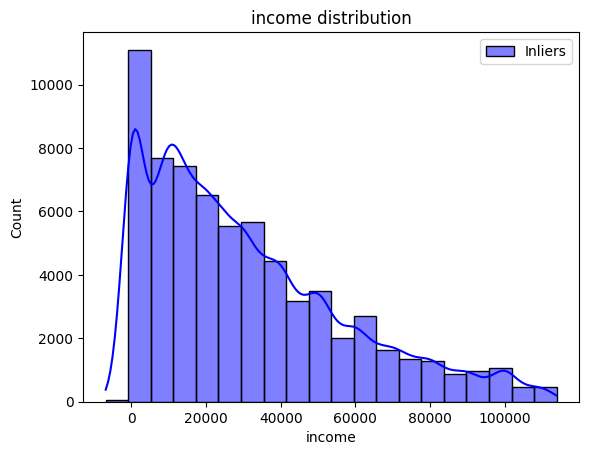

In [1112]:
utils.plot_numeric_dist('income', plot_outliers=False)

#### **2.3.4. Marital status**

##### **➜ Marital status Statistics**

In [1113]:
utils.print_stats(feature='marital_status')

| Label | Count | Percentage |
| --- | --- | --- |
| Married | 38040 | 52.50 % |
| Never married | 19120 | 26.39 % |
| Divorced/Separated | 10572 | 14.59 % |
| Widowed | 4726 | 6.52 % |


##### **➜ Marital status Distribution**

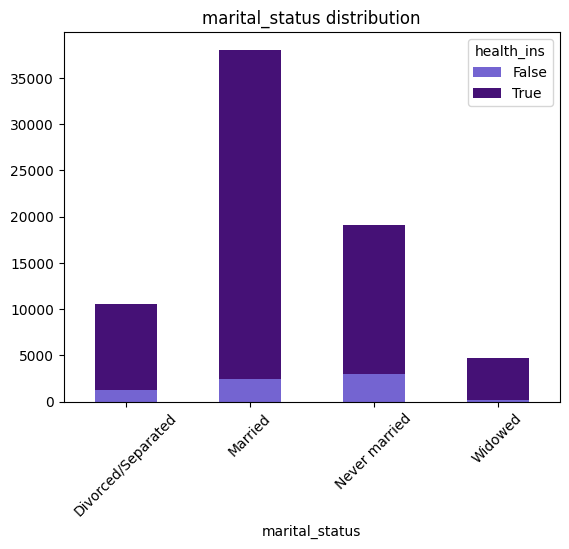

In [1114]:
utils.plot_dist(feature='marital_status')

#### **2.3.5. Health insurance**

##### **➜ Health insurance Statistics**

In [1115]:
utils.print_stats(feature='health_ins')

| Label | Count | Percentage |
| --- | --- | --- |
| True | 65553 | 90.47 % |
| False | 6905 | 9.53 % |


##### **➜ Health insurance Distribution**

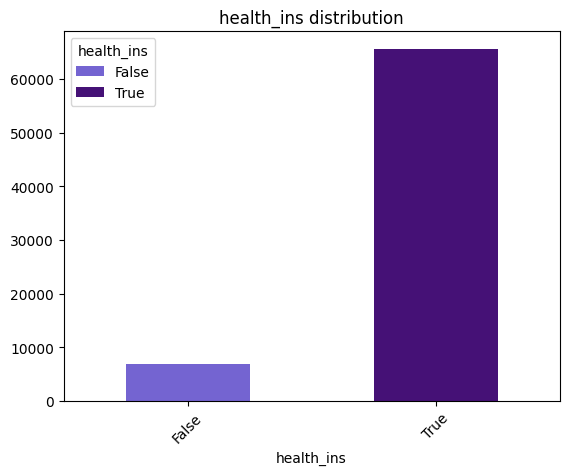

In [1116]:
utils.plot_dist(feature='health_ins')

#### **2.3.6. Housing type**

##### **➜ Housing type Statistics**

In [1117]:
utils.print_stats(feature='housing_type')

| Label | Count | Percentage |
| --- | --- | --- |
| Homeowner with mortgage/loan | 31092 | 42.91 % |
| Rented | 21956 | 30.30 % |
| Homeowner free and clear | 16604 | 22.92 % |
| Missing | 1686 | 2.33 % |
| Occupied with no rent | 1120 | 1.55 % |


##### **➜ Housing type Distribution**

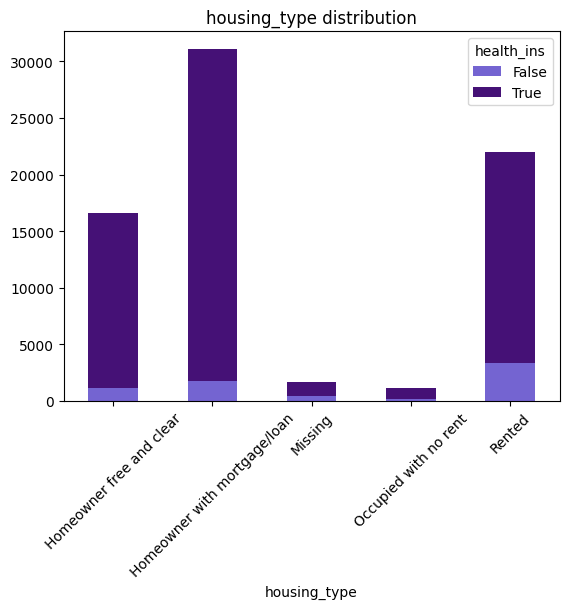

In [1118]:
utils.plot_dist(feature='housing_type')

#### **2.3.7. Number of vehicles**

##### **➜ Number of vehicles Statistics**

In [1119]:
utils.print_stats(feature='num_vehicles')

| Label | Count | Percentage |
| --- | --- | --- |
| 2.0 | 28052 | 38.71 % |
| 1.0 | 17445 | 24.08 % |
| 3.0 | 13094 | 18.07 % |
| 4.0 | 5100 | 7.04 % |
| 0.0 | 4636 | 6.40 % |
| Missing | 1686 | 2.33 % |
| 5.0 | 1628 | 2.25 % |
| 6.0 | 817 | 1.13 % |


##### **➜ Number of vehicles Distribution**

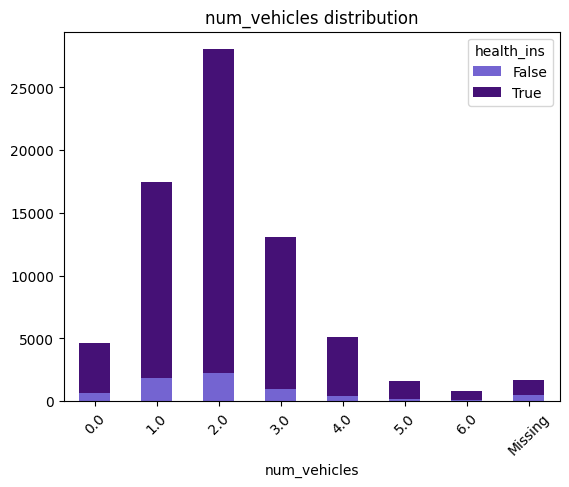

In [1120]:
utils.plot_dist(feature='num_vehicles')

#### **2.3.8. Age**

##### **➜ Age Statistics**

In [1121]:
utils.print_numeric_stats('age')

| Statistics | Value |
| --- | --- |
| Mean | 49.21 |
| Standard Deviation | 18.09 |
| Minimum | 0.00 |
| 25th percentile | 34.00 |
| Median | 48.00 |
| 75th percentile | 62.00 |
| Maximum | 120.00 || IQR | 28.00 || Skewness | 0.38 || Kurtosis | -0.39 || NA values | 0 |

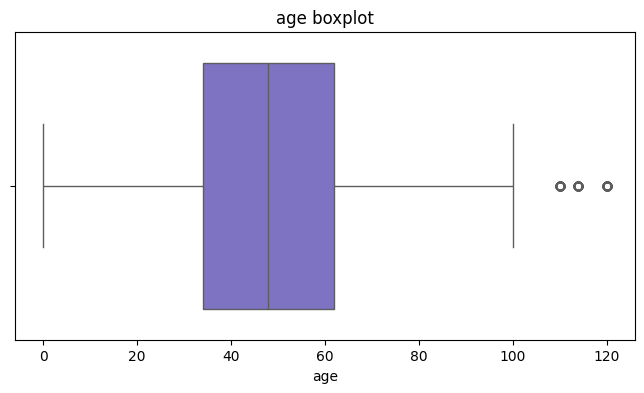

In [1122]:
utils.plot_stats('age')

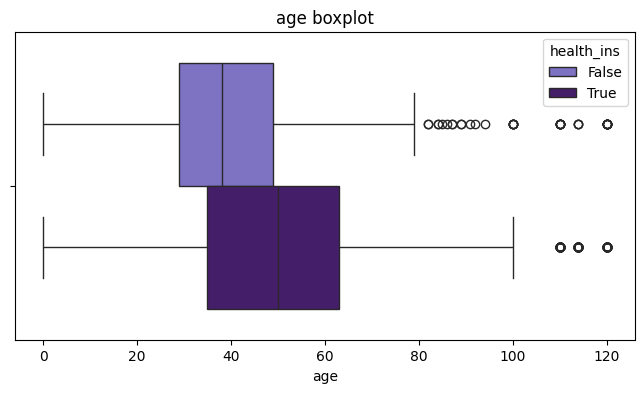

In [1123]:
utils.plot_stats('age', with_target_value=True)

##### **➜ Age Distribution**

Most of the customers are young or early 40s, between 18 and 45 years old.

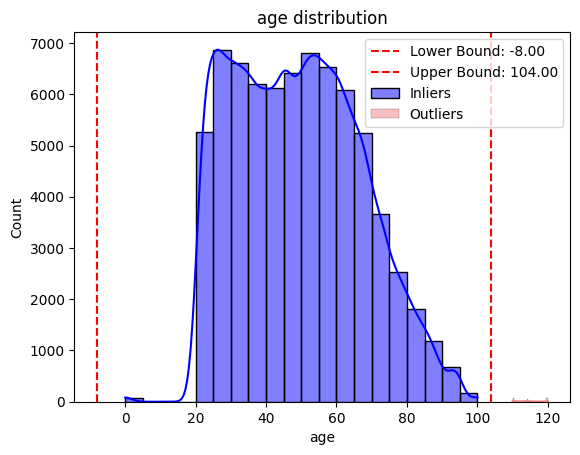

In [1124]:
utils.plot_numeric_dist('age')

#### **2.3.9. State of residence**

##### **➜ State of residence Statistics**

In [1125]:
utils.print_stats('state_of_res')

| Label | Count | Percentage |
| --- | --- | --- |
| California | 8870 | 12.24 % |
| Texas | 5938 | 8.20 % |
| Florida | 4921 | 6.79 % |
| New York | 4375 | 6.04 % |
| Pennsylvania | 2968 | 4.10 % |
| Illinois | 2896 | 4.00 % |
| Ohio | 2587 | 3.57 % |
| North Carolina | 2329 | 3.21 % |
| Michigan | 2246 | 3.10 % |
| Georgia | 2177 | 3.00 % |
| New Jersey | 2035 | 2.81 % |
| Virginia | 1922 | 2.65 % |
| Washington | 1663 | 2.30 % |
| Massachusetts | 1635 | 2.26 % |
| Arizona | 1510 | 2.08 % |
| Tennessee | 1489 | 2.05 % |
| Indiana | 1452 | 2.00 % |
| Missouri | 1388 | 1.92 % |
| Maryland | 1324 | 1.83 % |
| Wisconsin | 1294 | 1.79 % |
| Colorado | 1274 | 1.76 % |
| Minnesota | 1214 | 1.68 % |
| South Carolina | 1167 | 1.61 % |
| Louisiana | 1085 | 1.50 % |
| Alabama | 1037 | 1.43 % |
| Oregon | 942 | 1.30 % |
| Kentucky | 923 | 1.27 % |
| Oklahoma | 889 | 1.23 % |
| Connecticut | 827 | 1.14 % |
| Iowa | 702 | 0.97 % |
| Nevada | 665 | 0.92 % |
| Mississippi | 659 | 0.91 % |
| Utah | 657 | 0.91 % |
| Arkansas | 646 | 0.89 % |
| Kansas | 638 | 0.88 % |
| West Virginia | 416 | 0.57 % |
| Nebraska | 402 | 0.55 % |
| New Mexico | 399 | 0.55 % |
| Hawaii | 354 | 0.49 % |
| Idaho | 328 | 0.45 % |
| Maine | 319 | 0.44 % |
| New Hampshire | 305 | 0.42 % |
| Rhode Island | 218 | 0.30 % |
| Montana | 216 | 0.30 % |
| Delaware | 198 | 0.27 % |
| South Dakota | 186 | 0.26 % |
| North Dakota | 169 | 0.23 % |
| District of Columbia | 168 | 0.23 % |
| Alaska | 160 | 0.22 % |
| Vermont | 146 | 0.20 % |
| Wyoming | 130 | 0.18 % |


##### **➜ State of residence Distribution**

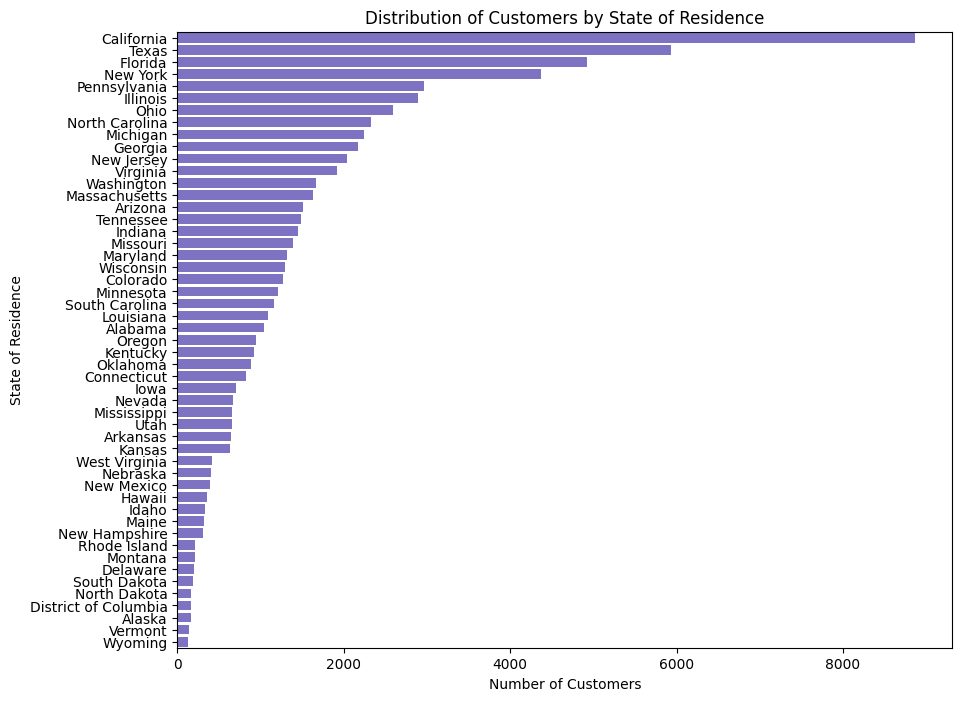

In [1126]:
plt.figure(figsize=(10, 8))
sns.countplot(y='state_of_res', data=df, order=df['state_of_res'].value_counts().index)
plt.title('Distribution of Customers by State of Residence')
plt.xlabel('Number of Customers')
plt.ylabel('State of Residence')
plt.show()

#### **2.3.10. Gas usage**

##### **➜ Gas usage Statistics**

In [1127]:
utils.print_numeric_stats('gas_usage')

| Statistics | Value |
| --- | --- |
| Mean | 41.23 |
| Standard Deviation | 63.15 |
| Minimum | 1.00 |
| 25th percentile | 3.00 |
| Median | 10.00 |
| 75th percentile | 60.00 |
| Maximum | 570.00 || IQR | 57.00 || Skewness | 3.03 || Kurtosis | 13.03 || NA values | 1686 |

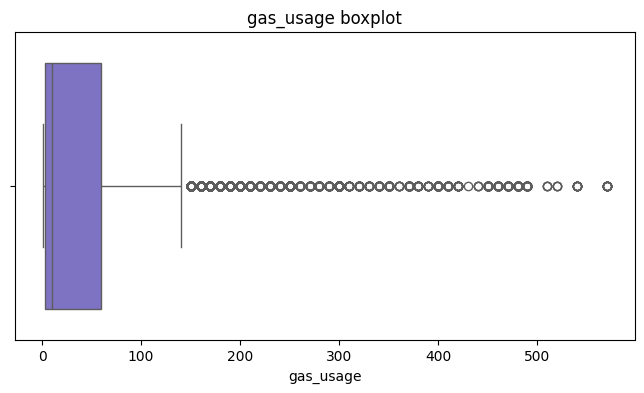

In [1128]:
utils.plot_stats('gas_usage')

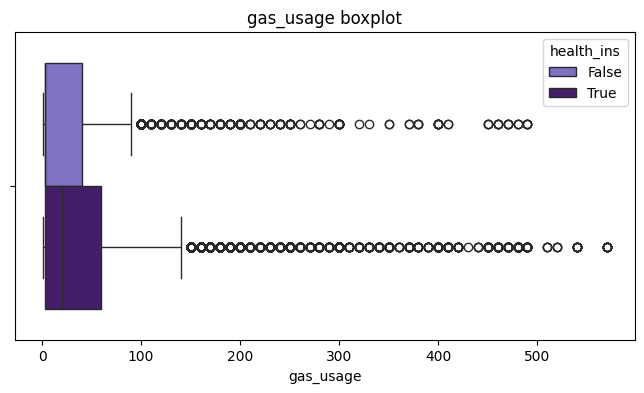

In [1129]:
utils.plot_stats('gas_usage', with_target_value=True)

##### **➜ Gas usage Distribution**

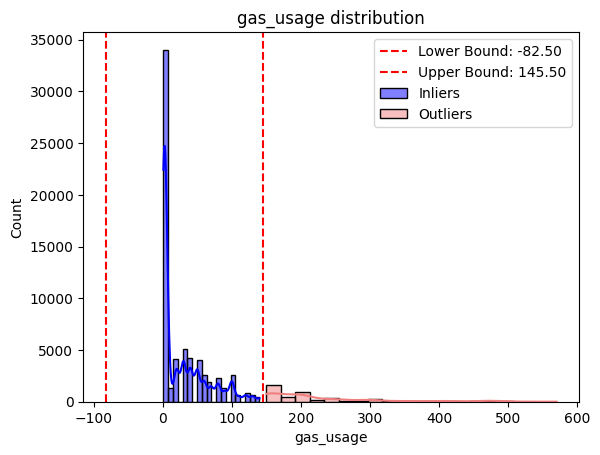

In [1130]:
utils.plot_numeric_dist('gas_usage')

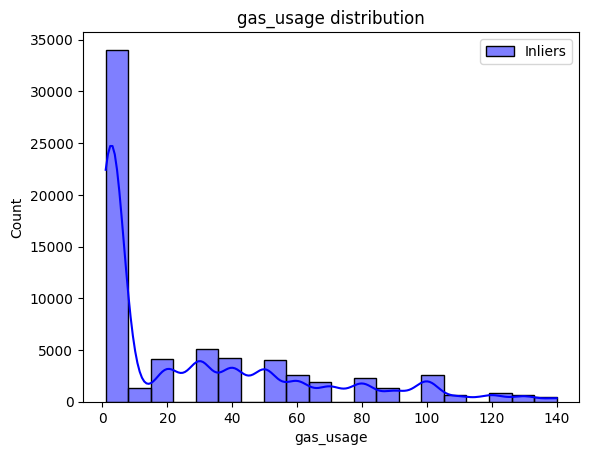

In [1131]:
utils.plot_numeric_dist('gas_usage', plot_outliers=False)

#### **2.3.11. Rooms**

##### **➜ Rooms Statistics**

In [1132]:
utils.print_stats('rooms')

| Label | Count | Percentage |
| --- | --- | --- |
| 2 | 12230 | 16.88 % |
| 3 | 12134 | 16.75 % |
| 5 | 12098 | 16.70 % |
| 1 | 12042 | 16.62 % |
| 6 | 11999 | 16.56 % |
| 4 | 11955 | 16.50 % |


##### **➜ Rooms Distribution**

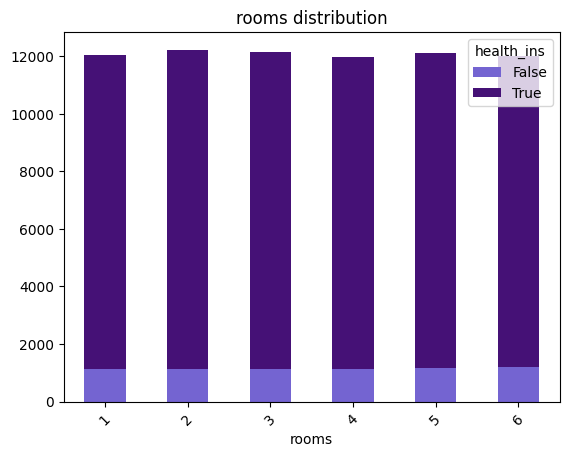

In [1133]:
utils.plot_dist('rooms')

#### **2.3.12. Recent move**

##### **➜ Recent move Statistics**

In [1134]:
utils.print_stats('recent_move_b')

| Label | Count | Percentage |
| --- | --- | --- |
| F | 61773 | 85.25 % |
| T | 8998 | 12.42 % |
| Missing | 1687 | 2.33 % |


##### **➜ Recent move Distribution**

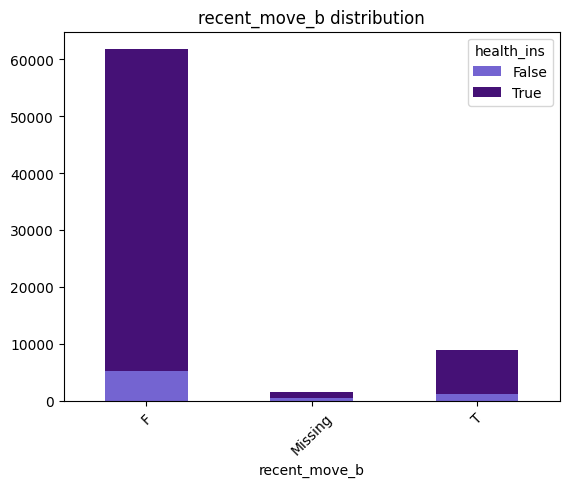

In [1135]:
utils.plot_dist('recent_move_b')

#### **2.3.13. Income by age group**

##### **➜ Scatterplot**

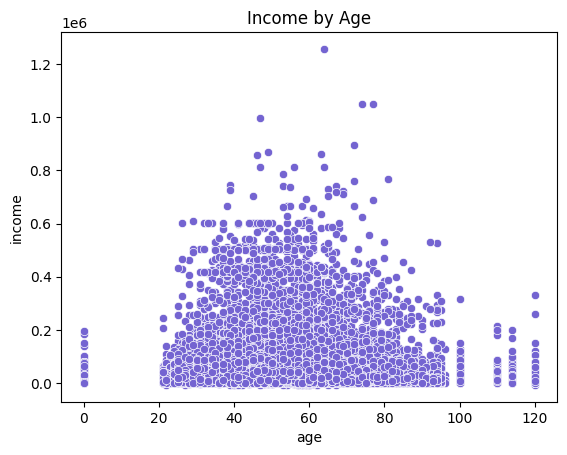

In [1136]:
sns.scatterplot(x='age', y='income', data=df)
plt.title('Income by Age')
plt.show()

##### **➜ Boxplot**

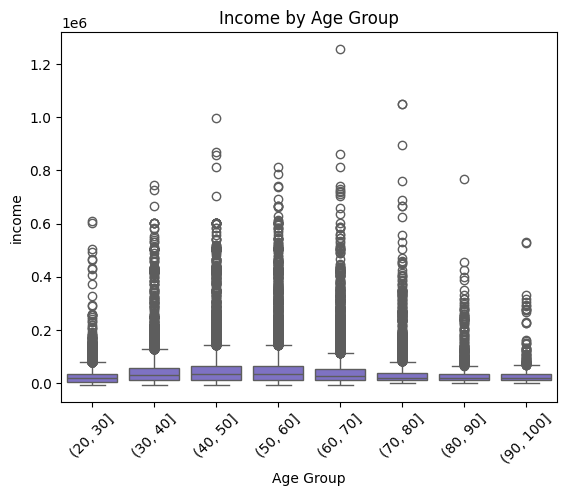

In [1137]:
sns.boxplot(x=pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100]), y='income', data=df)
plt.title('Income by Age Group')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.show()

#### **2.3.14. Probability of health insurance by age**

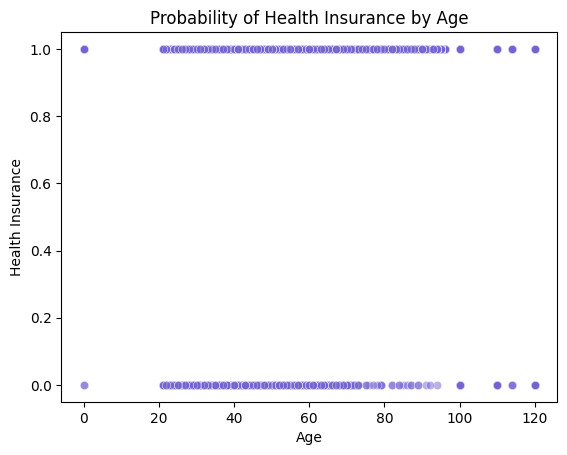

In [1138]:
sns.scatterplot(x='age', y='health_ins', data=df, alpha=0.5)
plt.title('Probability of Health Insurance by Age')
plt.xlabel('Age')
plt.ylabel('Health Insurance')
plt.show()

#### **2.3.15. Marital status by housing type**

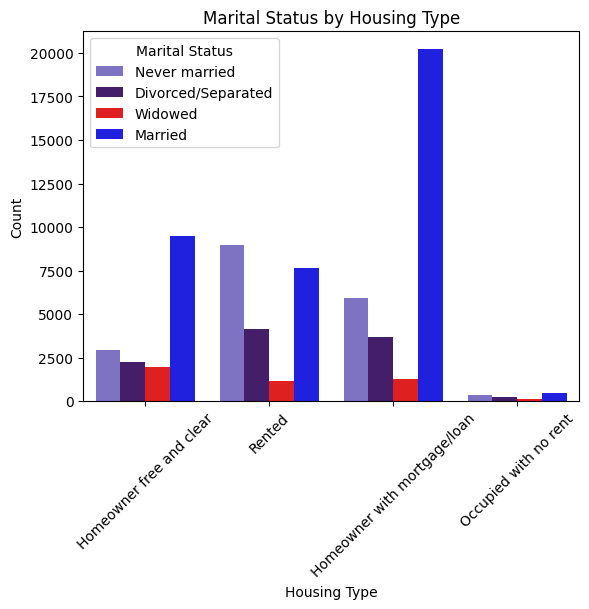

In [1139]:
sns.countplot(x='housing_type', hue='marital_status', data=df)
plt.title('Marital Status by Housing Type')
plt.xlabel('Housing Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Marital Status')
plt.show()

#### **2.3.16. Health insurance by marital status**

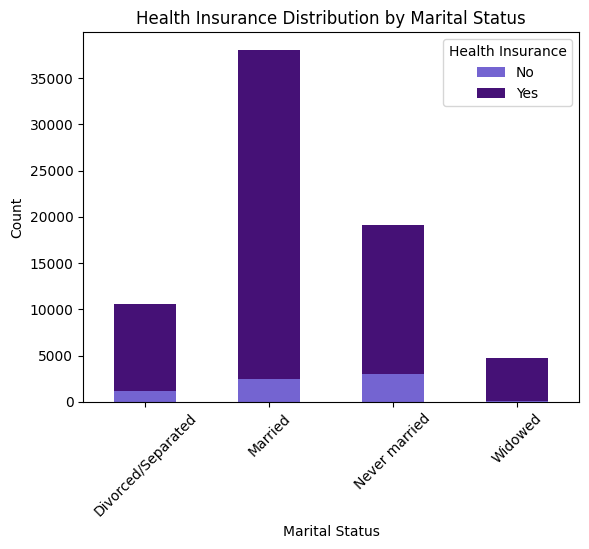

In [1140]:
pd.crosstab(df['marital_status'], df['health_ins']).plot(kind='bar', stacked=True)
plt.title('Health Insurance Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Health Insurance', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

#### **2.3.17. Correlation Matrix**

##### **➜ Correlation of rooms, housing_type_num, gas_usage**

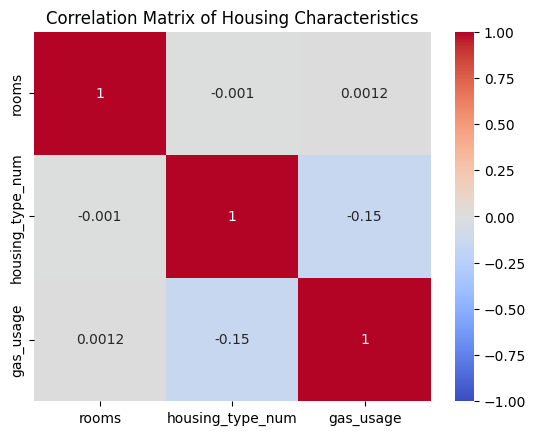

In [1141]:
df['housing_type_num'] = df['housing_type'].astype('category').cat.codes

correlation_matrix = df[['rooms', 'housing_type_num', 'gas_usage']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Housing Characteristics')
plt.show()

##### **➜ Correlation of numerical features**

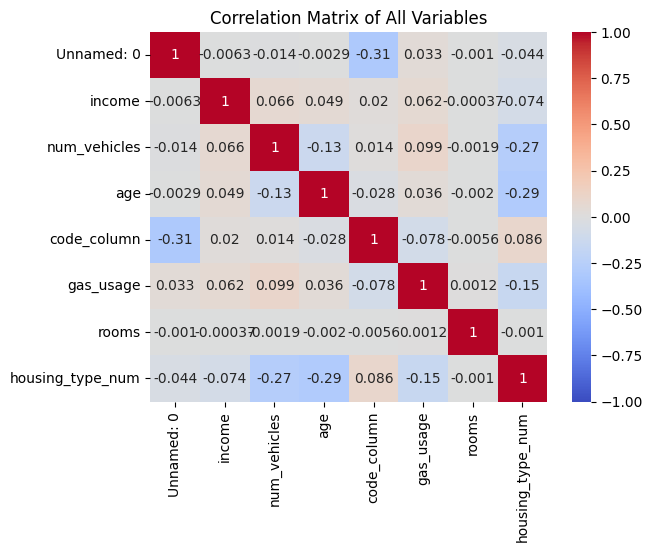

In [1142]:
numeric_df = df.select_dtypes(include=[np.number])

correlation_matrix_all = numeric_df.corr()

sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of All Variables')
plt.show()

df.drop(columns='housing_type_num', inplace=True)

---

## **3. Data Preparation**

### **3.1. Data Selection**

#### **➜ Drop unamed column and Customer ID**

In [1143]:
df.drop(columns=['Unnamed: 0', 'custid'], inplace=True)

#### **➜ Highly correlated features: State of Residence and Code Column**

In [1144]:
# Find states with more than one unique code_column
states_with_multiple_codes = df.groupby('state_of_res')['code_column'].nunique()
states_with_multiple_codes = states_with_multiple_codes[states_with_multiple_codes > 1]

# Display the result
print(states_with_multiple_codes)

####### THIS SHOULD BE MOVED TO DATA EXPLORATION

Series([], Name: code_column, dtype: int64)



Both attributes are directly associated, each State has a unique code. The code column can be dropped.

In [1145]:
df.drop(columns='code_column', inplace=True)

### **3.2. Data Cleaning**

#### **➜ Handling rows with many missing values**

In [1146]:
rows_with_missing = df.isnull().sum(axis=1) > 2
df.drop(df[rows_with_missing].index, inplace=True)

#### **➜ Handling null values** 

- Is employed:

In [1147]:
df['is_employed'] = df['is_employed'].fillna(False)

C:\Users\User\AppData\Local\Temp\ipykernel_7124\1078165704.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_employed'] = df['is_employed'].fillna(False)


- Number of vehicles

In [1148]:
df['num_vehicles'] = df['num_vehicles'].fillna(round(df['num_vehicles'].mean(),0))

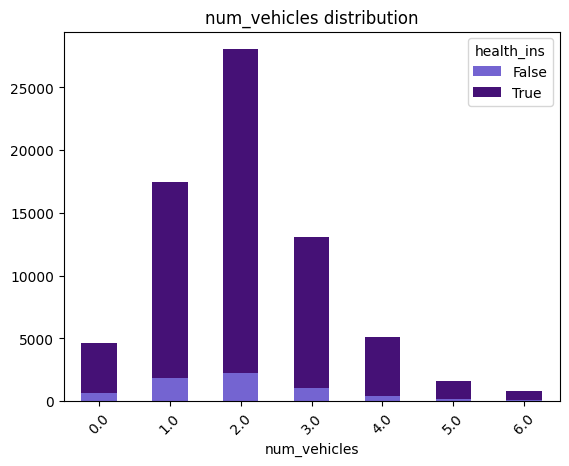

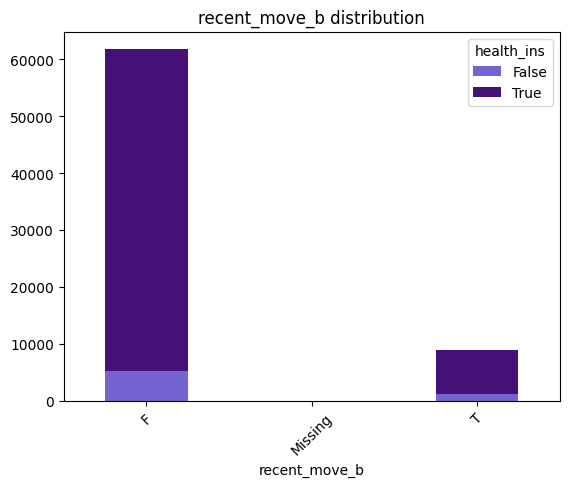

In [1149]:

## MOVE THIS TO DATA_PREPARATION - DATA DESCRIPTION
utils.plot_dist('num_vehicles')
utils.plot_dist('recent_move_b')

- Recent move

In [1150]:
df['recent_move_b'] = df['recent_move_b'].fillna(df['recent_move_b'].mode()[0])
df['recent_move_b'] = df['recent_move_b'].replace({'T': True, 'F': False})

C:\Users\User\AppData\Local\Temp\ipykernel_7124\1087636421.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['recent_move_b'] = df['recent_move_b'].replace({'T': True, 'F': False})


#### **➜ Handling age outliers**

In [1151]:
df['age'] = df['age'].replace(0, df['age'].median())
df = df[df["age"] != 120]

### **3.3. Data Construction**

#### **➜ Gas Usage and categories**

According to the data dictionary provided, the values of the gas usage attribute include some information beyond the actual monthly billing amount.

In [1152]:
def handle_gas_feature(df):
    gas_median = df[df['gas_usage'] > 3].gas_usage.median()

    non_bill_cases_values = {
        1: gas_median,
        2: gas_median,
        3: 0
    }
    non_bill_cases = {
        1: 'Included in rent', 
        2: 'Included in electricity', 
        3: 'No charge'
    }

    # New feature for gas usage category
    df['gas_category'] = df['gas_usage'].replace(non_bill_cases).where(
        df['gas_usage'].isin(non_bill_cases.keys()), 'Actual Bill'
    )
    df.loc[pd.isna(df['gas_usage']), 'gas_category'] = 'Unknown'

    # Replace non-bill cases' values or maintain if not included
    df['gas_usage'] = df['gas_usage'].replace(non_bill_cases_values)
    df['gas_usage'] = df['gas_usage'].fillna(gas_median)

    iqr = df['gas_usage'].quantile(0.75) - df['gas_usage'].quantile(0.25)
    lower_bound = df['gas_usage'].quantile(0.25) - 1.5 * iqr
    upper_bound = df['gas_usage'].quantile(0.75) + 1.5 * iqr

    df.loc[df['gas_usage'] < lower_bound, 'gas_usage'] = lower_bound
    df.loc[df['gas_usage'] > upper_bound, 'gas_usage'] = upper_bound

    df['gas_income'] = df['gas_usage'] * df['income']



In [1153]:
    
handle_gas_feature(df)

C:\Users\User\AppData\Local\Temp\ipykernel_7124\202634129.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gas_category'] = df['gas_usage'].replace(non_bill_cases).where(
C:\Users\User\AppData\Local\Temp\ipykernel_7124\202634129.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gas_usage'] = df['gas_usage'].replace(non_bill_cases_values)
C:\Users\User\AppData\Local\Temp\ipykernel_7124\202634129.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


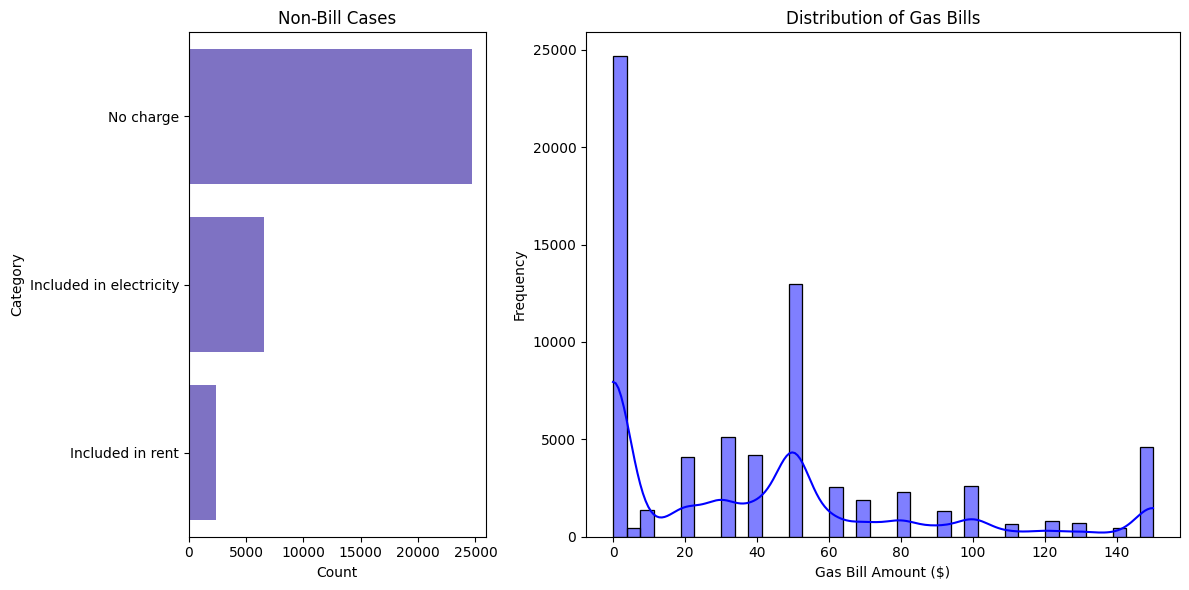

In [1154]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 2]})

# Bar chart for non-bill cases
non_bills = df[df['gas_category'] != 'Actual Bill']
non_bill_counts = non_bills['gas_category'].value_counts()
sns.barplot(x=non_bill_counts.values, y=non_bill_counts.index, ax=axes[0])
axes[0].set_title('Non-Bill Cases')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Category')

# Histogram for actual bills
sns.histplot(df['gas_usage'], bins=40, kde=True, ax=axes[1], color='blue')
axes[1].set_title('Distribution of Gas Bills')
axes[1].set_xlabel('Gas Bill Amount ($)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### **➜ Age x Income**

C:\Users\User\AppData\Local\Temp\ipykernel_7124\725648044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_income'] = df.age * df.income


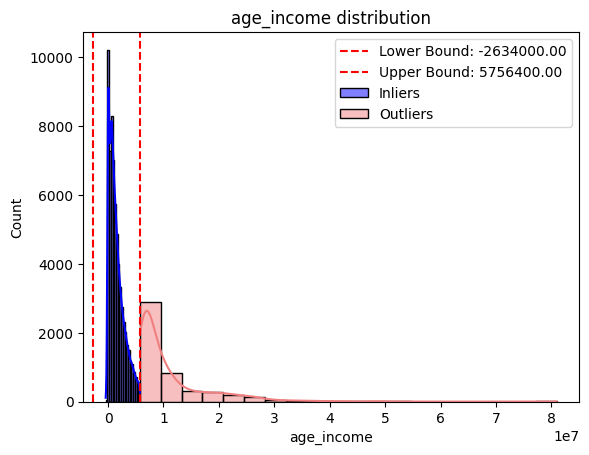

In [1155]:
df['age_income'] = df.age * df.income

utils.update_df(df)
utils.plot_numeric_dist('age_income')

#### **➜ Age x Vehicles**

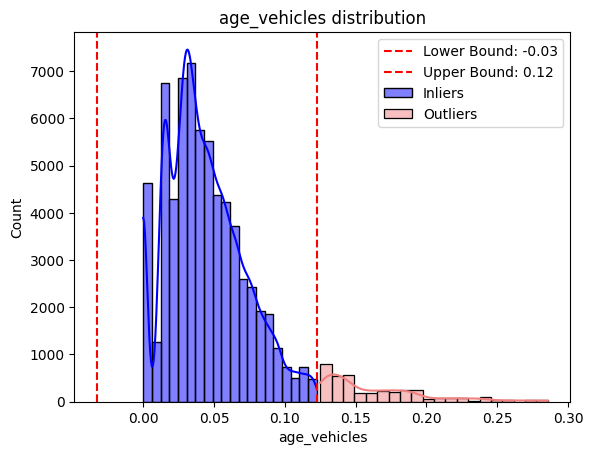

In [1156]:
df['age_vehicles'] = df['num_vehicles'] / df['age']

utils.update_df(df)
utils.plot_numeric_dist('age_vehicles')

### **3.4. Data Formatting**

In [1157]:
label_features = ['state_of_res']
categorical_features = ['sex','marital_status', 'housing_type', 'gas_category', 'recent_move_b', 'is_employed', 'health_ins'] 
numerical_features = ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms' ,'age_income','age_vehicles','gas_income']  

features = label_features + categorical_features + numerical_features

tree_preprocessor = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), label_features),
        ('onehot', OneHotEncoder(drop='first'), categorical_features),
        ('scaler', StandardScaler(), numerical_features)        
    ],
    remainder='passthrough'
)

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), label_features + categorical_features),
        ('scaler', StandardScaler(), numerical_features)        
    ],
    remainder='passthrough'
)

#### **3.4.3 Sampling**

##### **➜ Smote**

In [1158]:
def smote_data(X, y):
    smote = ADASYN(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

##### **➜ Oversampling**

In [1159]:
def oversample_data(X, y):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    return X_resampled, y_resampled

##### **➜ UnderSampling**

In [1160]:
def undersample_data(X, y):
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

---

## **4. Modelling**

In [1161]:
def determine_income_housing(row):
    if row['housing_type_Homeowner with mortgage/loan'] == 1:
        return 1
    elif row['housing_type_Occupied with no rent'] == 1:
        return 0.8
    return 0.6



def preprocess_dataframe(df, _preprocessor):
    _df = df.copy()
    
    x_processed = _preprocessor.fit_transform(_df)
        
    if _preprocessor == tree_preprocessor:
        feature_names = label_features + _preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features).tolist()
    else:
        feature_names = _preprocessor.named_transformers_['onehot'].get_feature_names_out(label_features + categorical_features).tolist()    

    feature_names += numerical_features
        
    # rename health_ins_True to health_ins
    feature_names = [name.replace('health_ins_True', 'health_ins') for name in feature_names]
        
    df_processed = pd.DataFrame(x_processed, columns=feature_names)
    df_processed['income_state'] = df_processed['income'] * df_processed['state_of_res']

    df_processed['income_housing'] = df_processed['income'] * df_processed.apply(determine_income_housing, axis=1)
    
    return df_processed

In [1162]:
def classify_split_then_sample(df, preprocessor, sample_function, params, classifier):
    # Preprocess data
    preprocessed_df = preprocess_dataframe(df, preprocessor)

    X = preprocessed_df.drop(columns='health_ins')  
    y = preprocessed_df['health_ins']
        
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Sample data
    X_resampled, y_resampled = sample_function(X_train, y_train)
    
    # Train model with GridSearchCV
    grid_search = GridSearchCV(estimator=classifier, param_grid=params, cv=5)
    
    grid_search.fit(X_resampled, y_resampled)
    
    # Predict
    y_pred = grid_search.predict(X_test)
    
    # Evaluate
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(report)
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confusion Matrix')
    plt.show()

In [1163]:
def classify_sample_then_split(df, preprocessor, sample_function, params, classifier):
    # Preprocess data
    preprocessed_df = preprocess_dataframe(df, preprocessor)
    
    X = preprocessed_df.drop(columns='health_ins')  
    y = preprocessed_df['health_ins']
        
    # Sample data
    X_resampled, y_resampled = sample_function(X, y)
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
    
    # Train model with GridSearchCV
    grid_search = GridSearchCV(estimator=classifier, param_grid=params, cv=5)
    grid_search.fit(X_train, y_train)
    # Predict
    y_pred = grid_search.predict(X_test)
    # Evaluate
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(report)
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confusion Matrix')
    plt.show()

#### **4.1 K-Nearest Neightbour**

In [1164]:
KNN_params = {
    'n_neighbors': [1, 3, 5, 7]
}

##### **4.1.1. With Undersample**

F1 Score: 0.6738082485270488
Accuracy: 0.6839647119875454
Best Parameters: {'n_neighbors': 7}
              precision    recall  f1-score   support

         0.0       0.68      0.71      0.69      1948
         1.0       0.69      0.66      0.67      1906

    accuracy                           0.68      3854
   macro avg       0.68      0.68      0.68      3854
weighted avg       0.68      0.68      0.68      3854



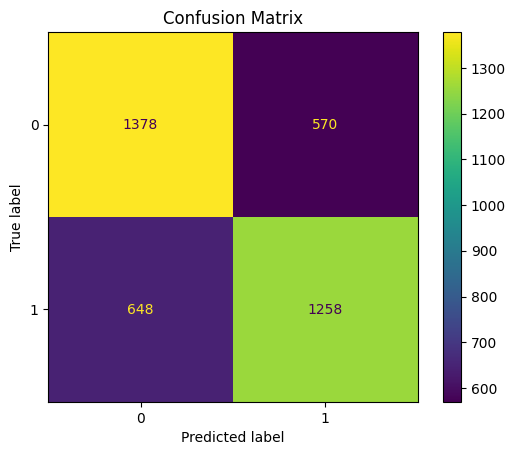

In [1165]:
classify_sample_then_split(df, tree_preprocessor, undersample_data, KNN_params, KNeighborsClassifier())

##### **4.1.2. With Oversample**

F1 Score: 0.9447244394802081
Accuracy: 0.94739707559888
Best Parameters: {'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     19219
         1.0       1.00      0.90      0.94     19353

    accuracy                           0.95     38572
   macro avg       0.95      0.95      0.95     38572
weighted avg       0.95      0.95      0.95     38572



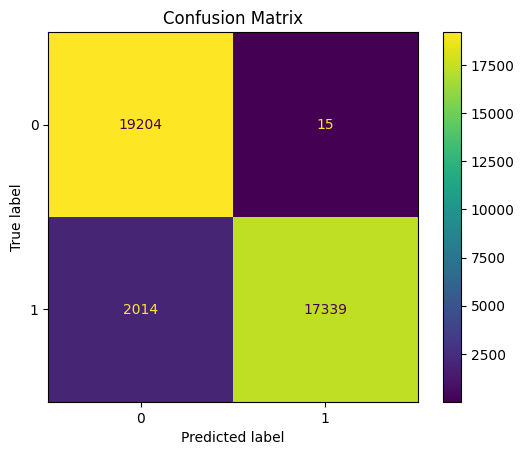

In [1166]:
classify_sample_then_split(df, tree_preprocessor, oversample_data, KNN_params, KNeighborsClassifier())

##### **4.1.3. With Smote**

F1 Score: 0.9021142422792151
Accuracy: 0.9095332257896654
Best Parameters: {'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92     19056
         1.0       0.99      0.83      0.90     19378

    accuracy                           0.91     38434
   macro avg       0.92      0.91      0.91     38434
weighted avg       0.92      0.91      0.91     38434



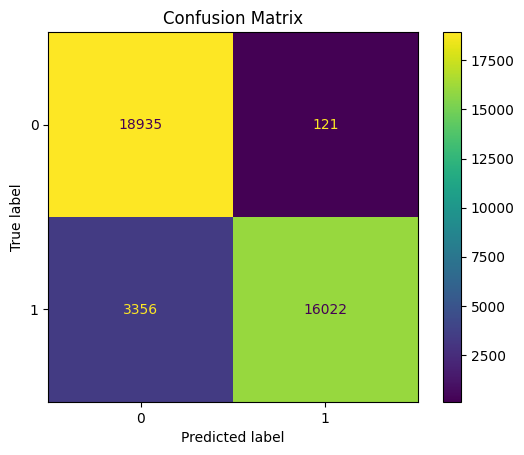

In [1167]:
classify_sample_then_split(df, tree_preprocessor, smote_data, KNN_params, KNeighborsClassifier())

#### **4.2 Gaussian Naive Bayes**

In [1168]:
gnb_params = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

F1 Score: 0.5102113937656754
Accuracy: 0.6453035806953814
Best Parameters: {'var_smoothing': np.float64(1.873817422860383e-08)}
              precision    recall  f1-score   support

         0.0       0.60      0.91      0.72      1948
         1.0       0.80      0.37      0.51      1906

    accuracy                           0.65      3854
   macro avg       0.70      0.64      0.62      3854
weighted avg       0.70      0.65      0.62      3854



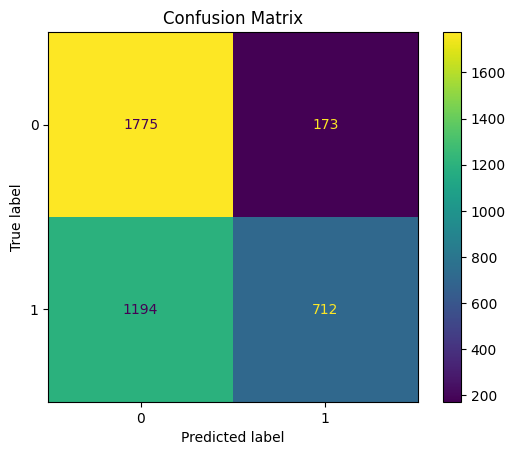

In [1169]:
classify_sample_then_split(df, tree_preprocessor, undersample_data, gnb_params, GaussianNB())

F1 Score: 0.5160786540782282
Accuracy: 0.6465311625012963
Best Parameters: {'var_smoothing': np.float64(3.5111917342151277e-07)}
              precision    recall  f1-score   support

         0.0       0.59      0.92      0.72     19219
         1.0       0.82      0.38      0.52     19353

    accuracy                           0.65     38572
   macro avg       0.71      0.65      0.62     38572
weighted avg       0.71      0.65      0.62     38572



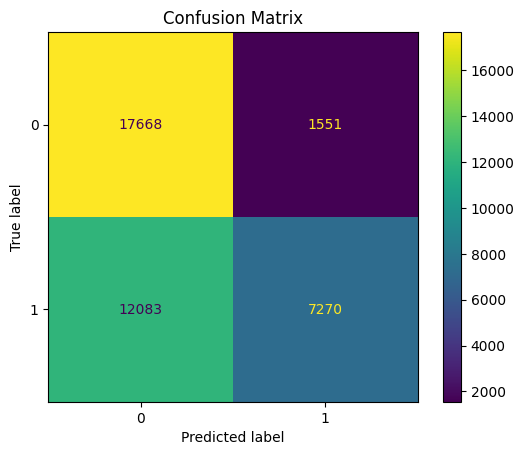

In [1170]:
classify_sample_then_split(df, tree_preprocessor, oversample_data, gnb_params, GaussianNB())

F1 Score: 0.508596503848644
Accuracy: 0.6445334859759588
Best Parameters: {'var_smoothing': np.float64(1.2328467394420658e-05)}
              precision    recall  f1-score   support

         0.0       0.59      0.93      0.72     19056
         1.0       0.84      0.36      0.51     19378

    accuracy                           0.64     38434
   macro avg       0.71      0.65      0.62     38434
weighted avg       0.72      0.64      0.61     38434



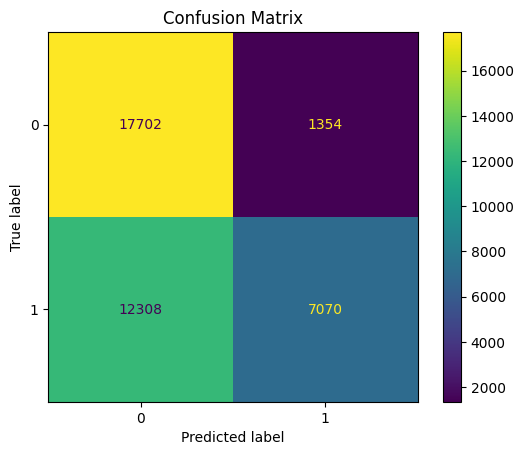

In [1171]:
classify_sample_then_split(df, tree_preprocessor, smote_data, gnb_params, GaussianNB())

#### **4.3 Decision Tree**

In [1172]:
tree_params = {
    'max_depth': [29],
    'criterion': ['gini'],
    'splitter': ['random'],
    'class_weight': ['balanced']
}

F1 Score: 0.6407867494824017
Accuracy: 0.6398546964193046
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 29, 'splitter': 'random'}
              precision    recall  f1-score   support

         0.0       0.65      0.63      0.64      1948
         1.0       0.63      0.65      0.64      1906

    accuracy                           0.64      3854
   macro avg       0.64      0.64      0.64      3854
weighted avg       0.64      0.64      0.64      3854



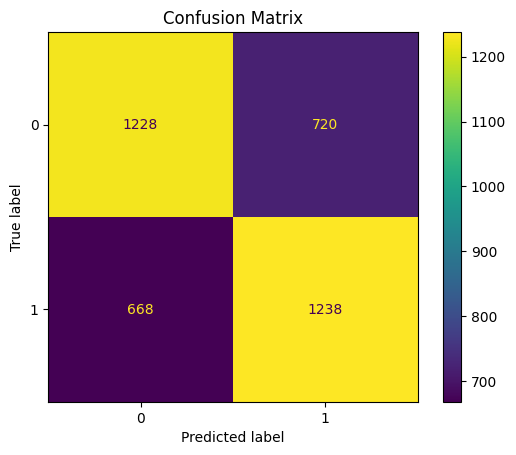

In [1173]:
classify_sample_then_split(df, tree_preprocessor, undersample_data, tree_params, DecisionTreeClassifier())


F1 Score: 0.9409353048897149
Accuracy: 0.9439749040754952
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 29, 'splitter': 'random'}
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     19219
         1.0       1.00      0.89      0.94     19353

    accuracy                           0.94     38572
   macro avg       0.95      0.94      0.94     38572
weighted avg       0.95      0.94      0.94     38572



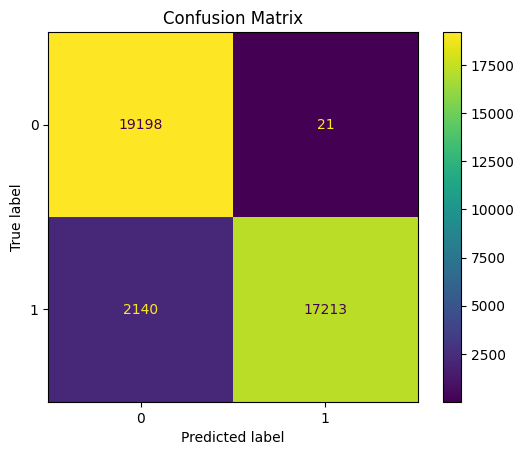

In [1174]:
classify_sample_then_split(df, tree_preprocessor, oversample_data, tree_params, DecisionTreeClassifier())

F1 Score: 0.9115710749460157
Accuracy: 0.8417008438221845
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 29, 'splitter': 'random'}
              precision    recall  f1-score   support

         0.0       0.22      0.29      0.25      1910
         1.0       0.93      0.90      0.91     19303

    accuracy                           0.84     21213
   macro avg       0.57      0.59      0.58     21213
weighted avg       0.86      0.84      0.85     21213



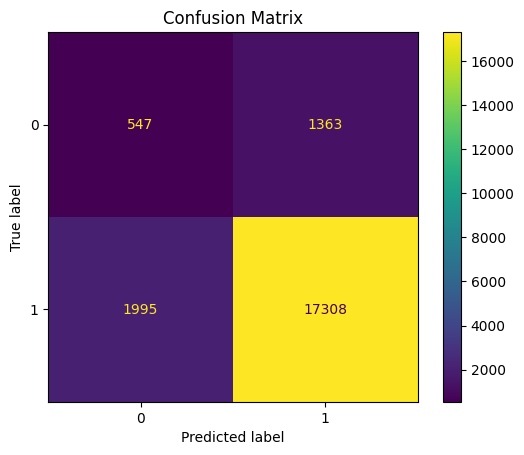

In [1175]:
classify_split_then_sample(df, tree_preprocessor, smote_data, tree_params, DecisionTreeClassifier())

#### **4.4 Random Forest**

In [1176]:
rf_params =  {'class_weight': ['balanced'], 'criterion': ['gini'], 'max_depth': [7], 'max_features': [5], 'min_samples_leaf': [1], 'n_estimators': [300], 'random_state': [42]}



F1 Score: 0.8308125413998675
Accuracy: 0.8405058021543426
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 42}
              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85     19056
         1.0       0.89      0.78      0.83     19378

    accuracy                           0.84     38434
   macro avg       0.85      0.84      0.84     38434
weighted avg       0.85      0.84      0.84     38434



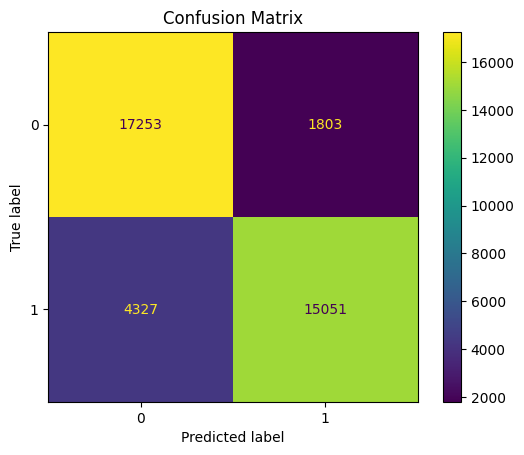

In [1177]:
classify_sample_then_split(df, tree_preprocessor, smote_data, rf_params, RandomForestClassifier())

#### **4.5 SVM** 

In [70]:
svm_params = {
    'C': [0.1, 1, 10, 100],                # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'degree': [2, 3, 4],                  # Degree of the polynomial kernel (if `kernel` is 'poly')
    'gamma': ['scale', 'auto'],           # Kernel coefficient
    'class_weight': ['balanced'],         # Handles imbalanced classes
    'probability': [True]                 # Enables probability estimates
}

In [ ]:
from sklearn.svm import SVC

classify_sample_then_split(df, tree_preprocessor, smote_data, svm_params, SVC())

#### **4.6 Neural Network**

In [1181]:
def create_nn_model():
    nn = Sequential()
    nn.add(layers.Dense(128, activation='relu', input_dim=23)) 
    nn.add(layers.Dense(64, activation='relu'))
    nn.add(layers.Dense(32, activation='relu'))
    nn.add(layers.Dense(1, activation='sigmoid')) 

    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return nn

In [1182]:
def classify_sample_then_split_nn(df,preprocessor,sample_data,nn):
    # Preprocess data
    preprocessed_df = preprocess_dataframe(df, preprocessor)

    X = preprocessed_df.drop(columns='health_ins')  
    y = preprocessed_df['health_ins']
        
    # Sample data
    X_resampled, y_resampled = sample_data(X, y)
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
    
    # Train model
    nn.fit(X_train, y_train, epochs=30, batch_size=32)
    
    # Predict
    y_pred = nn.predict(X_test)
    y_pred = (y_pred > 0.5)
    
    # Evaluate
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(report)
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title('Confusion Matrix')
    plt.show()

##### **4.6.1 With SMOTE** 

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 3s 697us/step - accuracy: 0.7018 - loss: 0.5796
Epoch 2/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - accuracy: 0.7443 - loss: 0.5167
Epoch 3/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 682us/step - accuracy: 0.7522 - loss: 0.5003
Epoch 4/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 678us/step - accuracy: 0.7652 - loss: 0.4813
Epoch 5/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 679us/step - accuracy: 0.7882 - loss: 0.4445
Epoch 6/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 669us/step - accuracy: 0.8046 - loss: 0.4104
Epoch 7/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 671us/step - accuracy: 0.8210 - loss: 0.3760
Epoch 8/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - accuracy: 0.8298 - loss: 0.3581
Epoch 9/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 667us/step - accuracy: 0.8407 - loss: 0.3368
Epoch 10/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 670us/step - accuracy: 0.8454 - loss: 0.3257
Epoch 11/30
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 681us/step - accuracy: 0.8496 - loss: 0.3156
Epoch 12

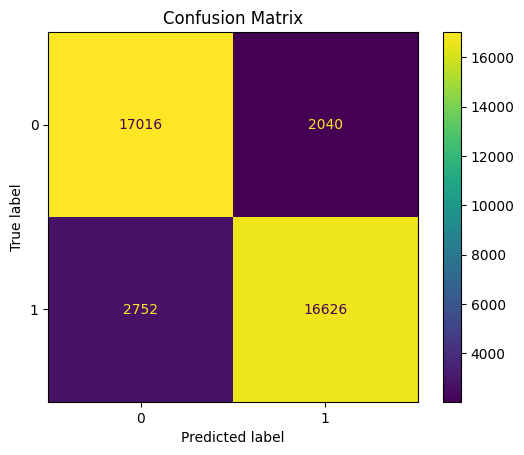

In [1183]:
nn = create_nn_model()

classify_sample_then_split_nn(df, tree_preprocessor, smote_data, nn)

K.clear_session()

##### **4.6.2 With OverSampling**

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 3s 745us/step - accuracy: 0.7102 - loss: 0.5748
Epoch 2/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 735us/step - accuracy: 0.7409 - loss: 0.5277
Epoch 3/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 738us/step - accuracy: 0.7423 - loss: 0.5199
Epoch 4/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 789us/step - accuracy: 0.7496 - loss: 0.5090
Epoch 5/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7544 - loss: 0.4984
Epoch 6/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7604 - loss: 0.4876
Epoch 7/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7646 - loss: 0.4791
Epoch 8/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7739 - loss: 0.4657
Epoch 9/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7757 - loss: 0.4617
Epoch 10/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7820 - loss: 0.4534
Epoch 11/30
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7842 - loss: 0.4470
Epoch 12/30
2813/2813 

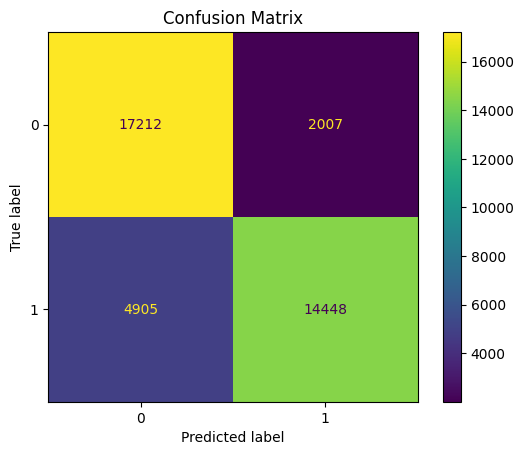

In [1184]:
nn = create_nn_model()

classify_sample_then_split_nn(df, tree_preprocessor, oversample_data, nn)

K.clear_session()

##### **4.6.3 With UnderSampling**

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6727 - loss: 0.6533
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7105 - loss: 0.5666
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7202 - loss: 0.5554
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7309 - loss: 0.5485
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7365 - loss: 0.5347
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7343 - loss: 0.5353
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7329 - loss: 0.5336
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7323 - loss: 0.5311
Epoch 9/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7352 - loss: 0.5250
Epoch 10/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7403 - loss: 0.5291
Epoch 11/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7367 - loss: 0.5258
Epoch 12/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

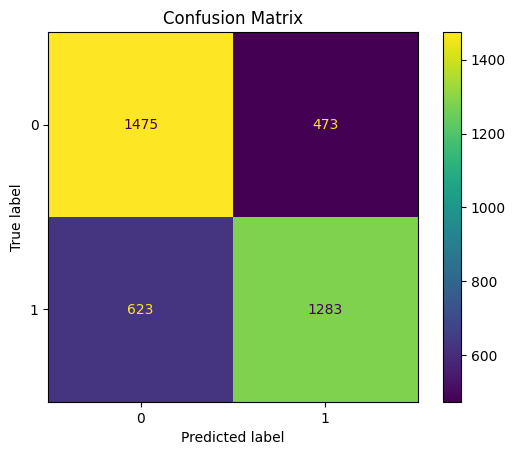

In [1185]:
nn = create_nn_model()

classify_sample_then_split_nn(df, tree_preprocessor, undersample_data, nn)

K.clear_session()

## Submission